In [153]:
from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"

import os
import zipfile
from typing import Dict

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
import seaborn as sns
from pymc_marketing.clv.utils import rfm_segments

In [158]:
pd.set_option("mode.copy_on_write", True)

## Data

In [155]:
url = "https://github.com/CapitalOneRecruiting/DS/blob/master/transactions.zip?raw=true"
local_directory = "../data/raw"
local_file_path = os.path.join(local_directory, "transactions.zip")

os.makedirs(local_directory, exist_ok=True)

response = requests.get(url)
if response.status_code == 200:
    with open(local_file_path, "wb") as file:
        file.write(response.content)
    print(f"File downloaded successfully to {local_file_path}")
else:
    print(f"Failed to download the file. Status code: {response.status_code}")

30522086

File downloaded successfully to ../data/raw/transactions.zip


In [156]:
with zipfile.ZipFile(local_file_path, "r") as zip_file:
    zip_file.extractall(local_directory)
    print(f"File extracted to {local_directory}")

File extracted to ../data/raw


In [157]:
columns_to_keep = [
    "accountNumber",
    "transactionAmount",
    "transactionDateTime",
    "isFraud",
]

data = pd.read_json(os.path.join(local_directory, "transactions.txt"), lines=True).loc[
    :, columns_to_keep
]

data.shape

(786363, 4)

Filter for non-fraudulent transactions:

In [159]:
data = data.loc[data["isFraud"] == False, list(set(data.columns) - set(["isFraud"]))]

data.shape

data.head()

(773946, 3)

,transactionAmount,accountNumber,transactionDateTime
0,98.55,737265056,2016-08-13T14:27:32
1,74.51,737265056,2016-10-11T05:05:54
2,7.47,737265056,2016-11-08T09:18:39
3,7.47,737265056,2016-12-10T02:14:50
4,71.18,830329091,2016-03-24T21:04:46


### Sanitize Data

#### Rename Snake Case

In [160]:
data.rename(
    columns={
        "accountNumber": "account_number",
        "transactionAmount": "transaction_amount",
        "transactionDateTime": "transaction_datetime",
    },
    inplace=True,
)

#### Ensure No Missing Values

In [161]:
data.isna().sum(axis=0)

transaction_amount      0
account_number          0
transaction_datetime    0
dtype: int64

#### Optimize Data Types

In [162]:
print(f"Memory usage before: {data.memory_usage().sum() / 1024**2:.2f} MB")

data.dtypes

data["transaction_amount"].describe()

Memory usage before: 23.62 MB


transaction_amount      float64
account_number            int64
transaction_datetime     object
dtype: object

count    773946.000000
mean        135.570249
std         146.525305
min           0.000000
25%          33.190000
50%          86.760000
75%         189.390000
max        2011.540000
Name: transaction_amount, dtype: float64

In [163]:
data = data.astype(
    {
        "transaction_amount": pd.Float32Dtype(),
        "transaction_datetime": "datetime64[ns]",
        "account_number": pd.StringDtype(),
    }
)

data.dtypes

print(f"Memory usage before: {data.memory_usage().sum() / 1024**2:.2f} MB")

transaction_amount             Float32
account_number          string[python]
transaction_datetime    datetime64[ns]
dtype: object

Memory usage before: 21.40 MB


In [165]:
os.makedirs("../data/processed", exist_ok=True)

data.to_parquet("../data/processed/transactions.parquet")

## Transaction Amounts

### Violin Plot

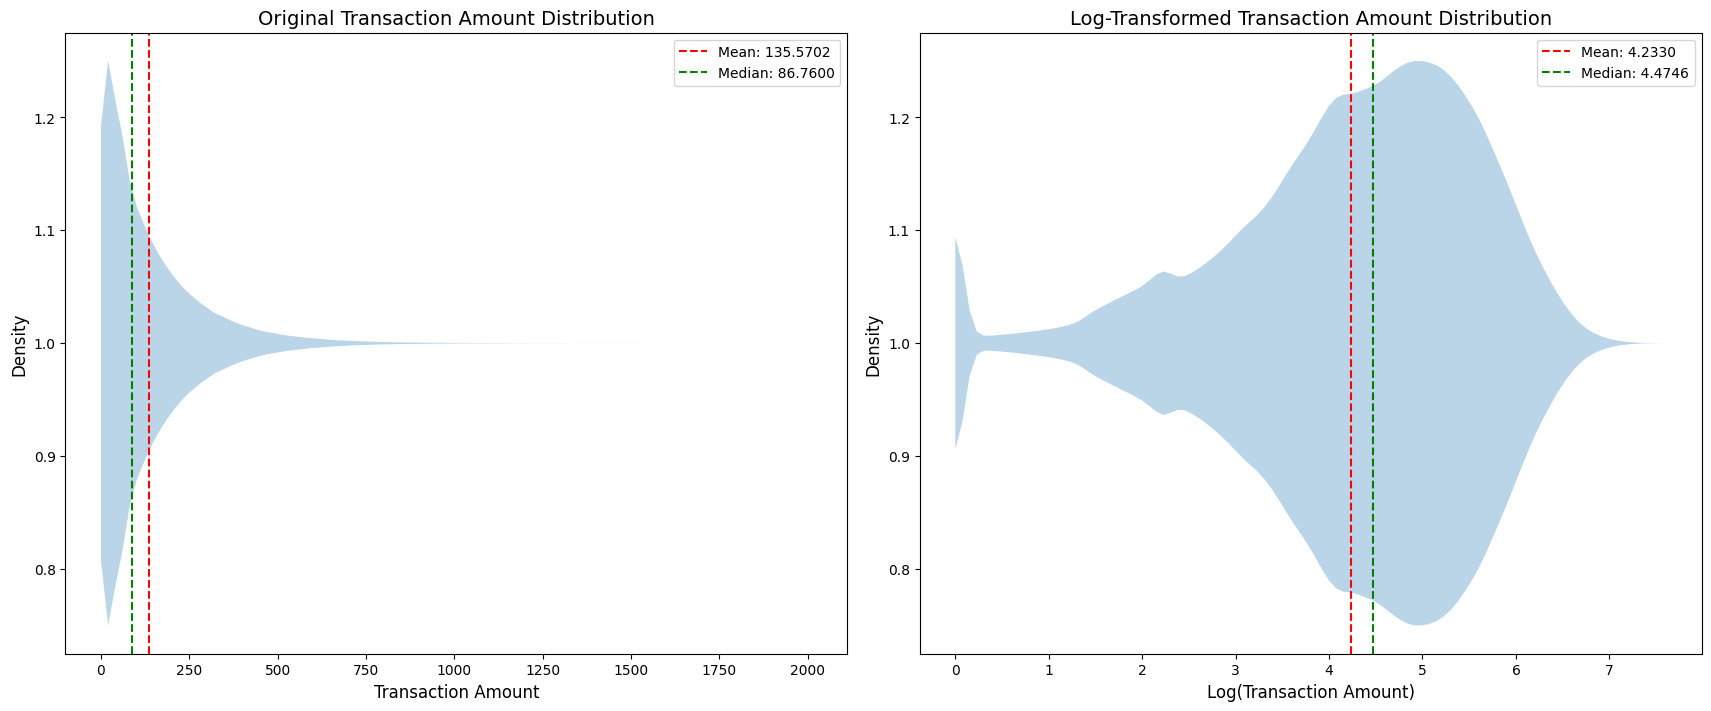

In [166]:
transaction_amount = data["transaction_amount"].to_numpy()
log_transaction_amount = np.log1p(transaction_amount)

mean_value = np.mean(transaction_amount)
median_value = np.median(transaction_amount)
log_mean_value = np.mean(log_transaction_amount)
log_median_value = np.median(log_transaction_amount)

fig, axes = plt.subplots(1, 2, figsize=(17, 7), constrained_layout=True)

# Original transaction amount distribution
axes[0].violinplot(
    transaction_amount,
    vert=False,
    showmeans=False,
    showmedians=False,
    showextrema=False,
)
axes[0].axvline(
    mean_value, color="red", linestyle="--", label=f"Mean: {mean_value:.4f}"
)
axes[0].axvline(
    median_value, color="green", linestyle="--", label=f"Median: {median_value:.4f}"
)
axes[0].set_title("Original Transaction Amount Distribution", fontsize=14)
axes[0].set_xlabel("Transaction Amount", fontsize=12)
axes[0].set_ylabel("Density", fontsize=12)
axes[0].legend()

# Log-transformed transaction amount distribution
axes[1].violinplot(
    log_transaction_amount,
    vert=False,
    showmeans=False,
    showmedians=False,
    showextrema=False,
)
axes[1].axvline(
    log_mean_value, color="red", linestyle="--", label=f"Mean: {log_mean_value:.4f}"
)
axes[1].axvline(
    log_median_value,
    color="green",
    linestyle="--",
    label=f"Median: {log_median_value:.4f}",
)
axes[1].set_title("Log-Transformed Transaction Amount Distribution", fontsize=14)
axes[1].set_xlabel("Log(Transaction Amount)", fontsize=12)
axes[1].set_ylabel("Density", fontsize=12)
axes[1].legend()

plt.show();

### Quantiles

In [167]:
data["transaction_amount"].describe(percentiles=[0.25, 0.5, 0.75, 0.95, 0.99])

count       773946.0
mean      135.570236
std       146.525314
min              0.0
25%        33.189999
50%        86.760002
75%       189.389999
95%       429.747498
99%       670.055493
max      2011.540039
Name: transaction_amount, dtype: Float64

## Recency, Frequency, Monetary Value

### Segments

In [168]:
segments = rfm_segments(
    transactions=data,
    customer_id_col="account_number",
    datetime_col="transaction_datetime",
    monetary_value_col="transaction_amount",
)

In [169]:
segments

,customer_id,frequency,recency,monetary_value,rfm_score,segment
0,100088067,66.0,2.0,116.945152,332,Repeat Customer
1,100108752,18.0,14.0,55.441666,111,Inactive Customer
2,100328049,88.0,2.0,136.263412,333,Premium Customer
3,100663626,30.0,1.0,214.075668,424,Top Spender
4,100737756,132.0,7.0,230.168945,244,Repeat Customer
...,...,...,...,...,...,...
4993,999086814,301.0,0.0,315.968353,444,Premium Customer
4994,999257059,128.0,6.0,201.295700,244,Repeat Customer
4995,999258704,78.0,2.0,107.183205,332,Repeat Customer
4996,999283629,118.0,0.0,174.567032,443,Premium Customer


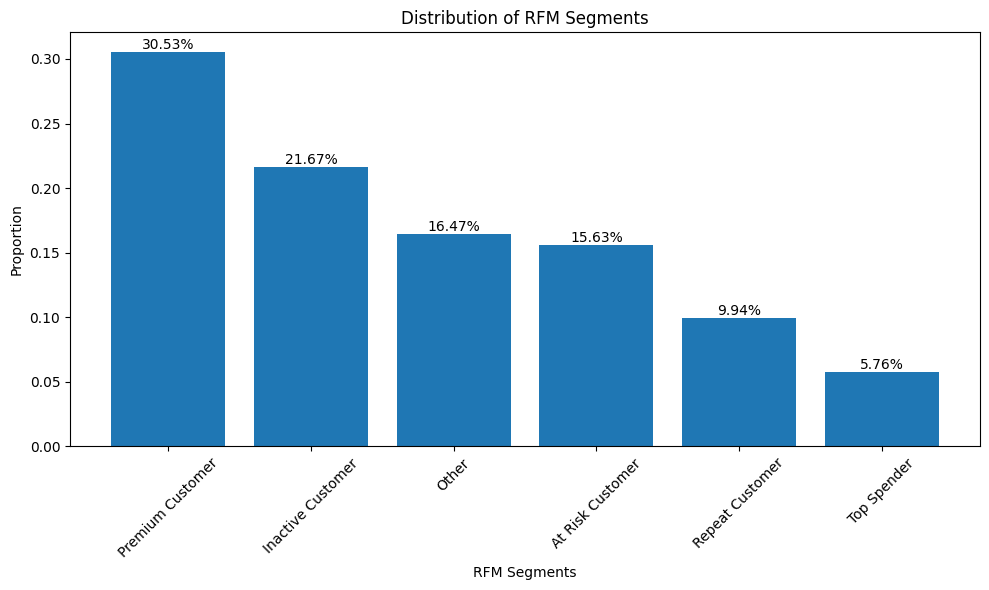

In [170]:
segment_counts = segments["segment"].value_counts(normalize=True)

plt.figure(figsize=(10, 6))
bars = plt.bar(segment_counts.index, segment_counts.values)

for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height,
        f"{height:.2%}",
        ha="center",
        va="bottom",
        fontsize=10,
    )

plt.xlabel("RFM Segments")
plt.ylabel("Proportion")
plt.title("Distribution of RFM Segments")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show();

### Distributions of Recency, Frequency, Monetary Value

In [171]:
def plot_rfm_violin(
    data: pd.DataFrame,
    quantile_thresholds: Dict[str, float] = {
        "monetary_value": 1.0,
        "recency": 1.0,
        "frequency": 1.0,
    },
) -> None:
    """
    Plot violin plots for monetary value, recency, and frequency grouped by segment,
    with horizontal lines indicating the mean and median values.

    This function applies quantile filters to remove outliers from the data and then
    creates separate violin plots for each metric. For each segment in a plot, a red
    horizontal line is drawn on the left side of the violin to represent the mean,
    and a blue horizontal line is drawn on the right side to represent the median.

    Parameters
    ----------
    data : pd.DataFrame
        DataFrame containing the columns 'segment', 'monetary_value', 'recency', and 'frequency'.
    quantile_thresholds : Dict[str, float], optional
        Dictionary specifying quantile thresholds for filtering outliers.
        For example, {'monetary_value': 0.95, 'recency': 0.90, 'frequency': 0.98}.
        The default (1.0 for each metric) applies no filtering.

    Returns
    -------
    None
    """
    # Apply quantile filters to remove outliers
    filtered_data = data.copy()
    for col, q in quantile_thresholds.items():
        threshold = filtered_data[col].quantile(q)
        filtered_data = filtered_data[filtered_data[col] <= threshold]

    # Determine the order of segments to ensure consistency between the violin plots and annotations.
    order = sorted(filtered_data["segment"].unique())

    # Define metrics and their titles
    metrics = ["monetary_value", "recency", "frequency"]
    titles = ["Monetary Value by Segment", "Recency by Segment", "Frequency by Segment"]

    # Create a grid of subplots (one row per metric)
    fig, axes = plt.subplots(len(metrics), 1, figsize=(10, 5 * len(metrics)))

    # Ensure axes is iterable in case of a single subplot
    if len(metrics) == 1:
        axes = [axes]

    # Loop over each metric and its corresponding axis
    for ax, metric, title in zip(axes, metrics, titles):
        # Plot the violin plot using the defined order
        sns.violinplot(
            x="segment",
            y=metric,
            hue="segment",
            data=filtered_data,
            order=order,
            ax=ax,
            inner=None,
            palette="muted",
            legend=False,
        )

        # Calculate summary statistics for the current metric per segment
        mean_points = filtered_data.groupby("segment")[metric].mean()
        median_points = filtered_data.groupby("segment")[metric].median()

        # Get the y-axis range and compute a vertical offset for text annotations
        y_min, y_max = ax.get_ylim()
        y_offset = (y_max - y_min) * 0.02  # 2% of the y-range

        # For each segment (in the defined order), draw horizontal lines and annotate values
        for i, segment in enumerate(order):
            mean_val = mean_points[segment]
            median_val = median_points[segment]

            # Draw a red horizontal line for the mean
            ax.hlines(
                mean_val,
                i - 0.3,
                i - 0.1,
                colors="red",
                lw=3,
                label="Mean" if i == 0 else "",
            )
            # Draw a blue horizontal line for the median
            ax.hlines(
                median_val,
                i + 0.1,
                i + 0.3,
                colors="blue",
                lw=3,
                label="Median" if i == 0 else "",
            )
            # Annotate the mean value above the mean bar
            ax.text(
                i - 0.32,
                mean_val + y_offset,
                f"{mean_val:.1f}",
                color="red",
                ha="right",
                va="bottom",
                fontsize=11,
            )
            # Annotate the median value above the median bar
            ax.text(
                i + 0.32,
                median_val + y_offset,
                f"{median_val:.1f}",
                color="blue",
                ha="left",
                va="bottom",
                fontsize=11,
            )

        # Add legend on the first subplot only
        if ax == axes[0]:
            ax.legend(loc="upper right")

        ax.set_title(title)
        ax.set_xlabel("Segment")
        ax.set_ylabel(metric.replace("_", " ").capitalize())

    plt.tight_layout()
    plt.show()

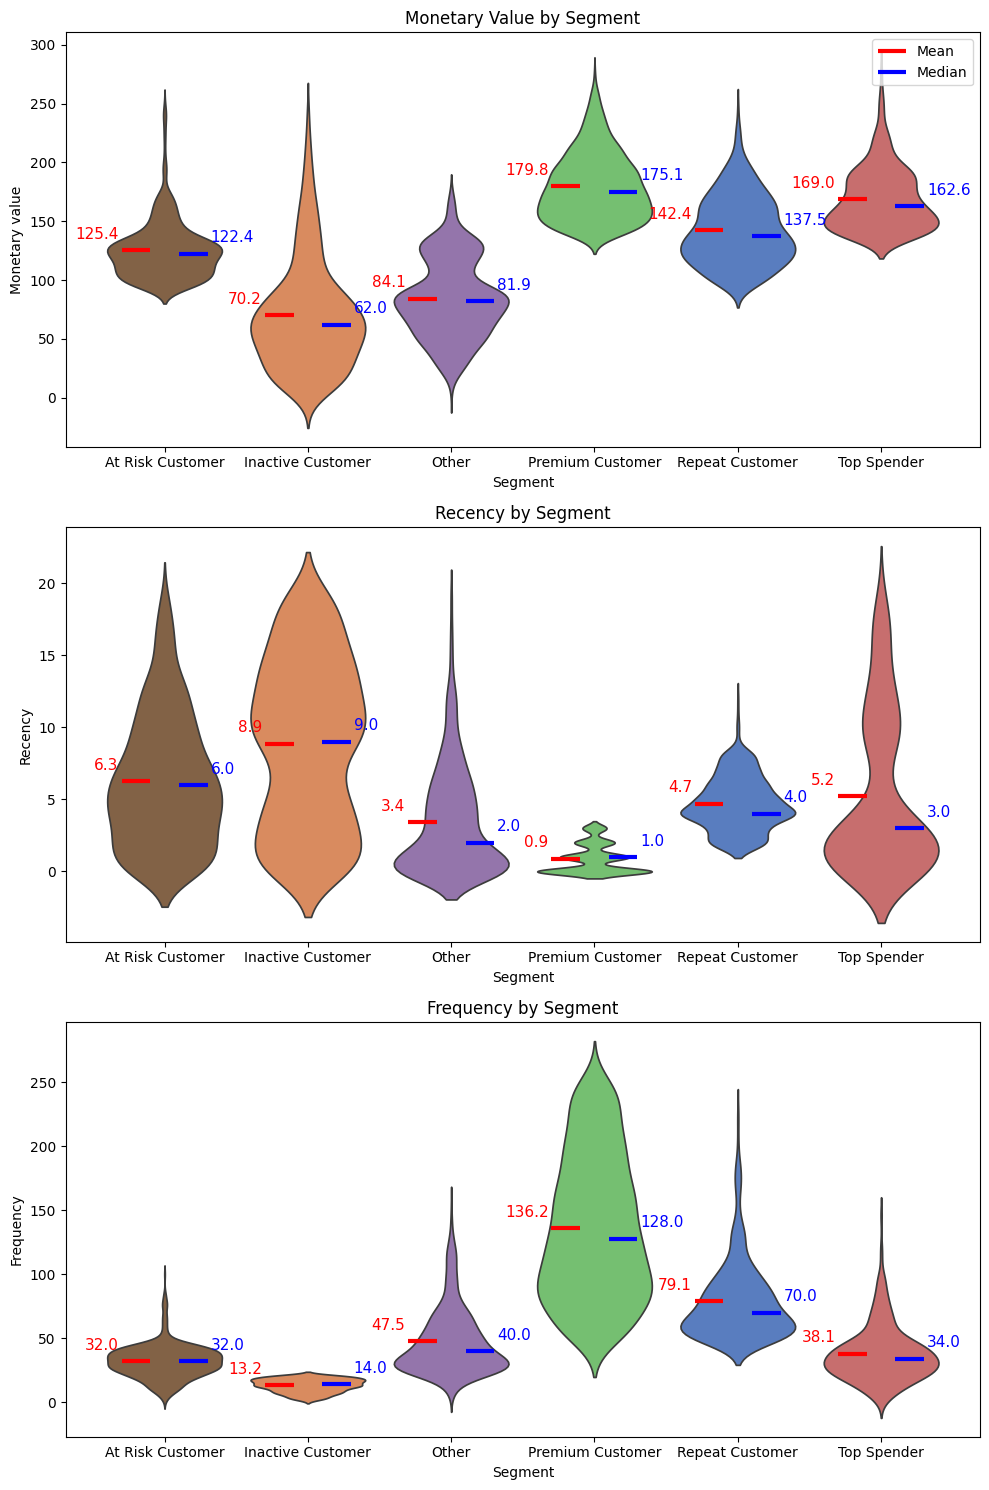

In [172]:
plot_rfm_violin(
    data=segments,
    quantile_thresholds={"monetary_value": 0.95, "recency": 0.90, "frequency": 0.98},
)

### RFM Score VS Segments

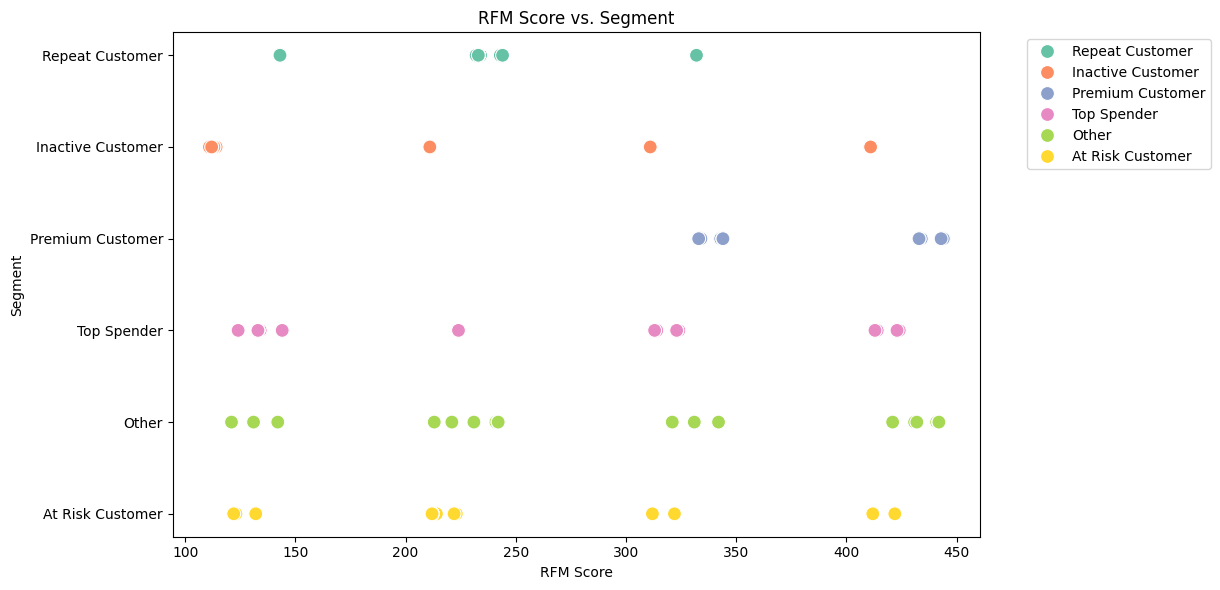

In [182]:
# Create a scatter plot of RFM score vs. segment
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=segments.astype({"rfm_score": pd.Int16Dtype()}),
    x="rfm_score",
    y="segment",
    hue="segment",
    palette="Set2",
    s=100,
)
plt.title("RFM Score vs. Segment")
plt.xlabel("RFM Score")
plt.ylabel("Segment")
plt.tight_layout()
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.show();